# ISML - Assignment03

Data is a subsampled version of the MNIST dataset. It contains images for 10 digits (10 classes). The dataset contains 6,000 samples. The images from the data set have the size 28 x 28. They are saved in the csv data files. Every line of these files consists of an image, i.e. 785 numbers between 0 and 1. The first number of each line is the label, i.e. the digit which is depicted in the image. The following 784 numbers are the pixels of the 28 x 28 image.

### Setup

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
np.random.seed(42)

# Load dataset
df = pd.read_csv('~/Documents/mnist.csv', header=None)

# Rename the first column as 'label' and the rest as 'pixel_1', 'pixel_2', ..., 'pixel_784'
column_names = ['label'] + [f'pixel_{i}' for i in range(1, 785)]
df.columns = column_names

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Columns: 785 entries, label to pixel_784
dtypes: float64(785)
memory usage: 35.9 MB


In [16]:
y = df.iloc[:, :1]
X = df.iloc[:, 1:]
k=10

## Question 01

Perform PCA on the dataset to reduce each sample into a 10-dimensional feature vector. Show the covariance matrix of the transformed data. Please also copy your code snippet here. 

### Results with Custom Implementation

In [17]:
class customPCA:
    def __init__(self, x, n_components=None):
        self.x = x
        self.n_components = n_components
        self.num_samples, self.num_features = x.shape
        self.cov_mat = None
        self.P = None
        self.y = None

    def cov(self):
        self.cov_mat = np.cov(self.x.T)
        return self.cov_mat
    
    def standardization(self):
        return self.x - np.mean(self.x, axis=0)  # Mean centering the data
    
    def reduce_feature(self):
        x_meaned = self.standardization()  # Step 1: Mean centering the data
        x_cov = self.cov()  # Step 2: Compute covariance matrix
        eigen_val, eigen_vec = np.linalg.eig(x_cov)  # Step 3: Eigen decomposition
        
        # Step 4: Sort eigenvalues and corresponding eigenvectors in descending order
        sort_index = np.argsort(eigen_val)[::-1]  # Sort in descending order
        sorted_eigenval = eigen_val[sort_index]
        sorted_eigenvector = eigen_vec[:, sort_index]
        
        # Select the top `n_components` eigenvectors
        self.P = sorted_eigenvector[:, :self.n_components]
        
        # Step 5: Transform the data using the selected principal components
        self.y = np.dot(x_meaned, self.P)
        return self.y

# Perform PCA to reduce to 10 dimensions
pca1 = customPCA(X, n_components=k) # Custom implementation
transformed_pca1 = pca1.reduce_feature()

print(f'\nUsing custom PCA:')
print(f'The input x has shape {X.shape}, and the transformed X has shape {transformed_pca1.shape}')
print(f'The sum of the input covariance matrix is {round(np.sum(pca1.cov_mat), 5)}.')
print(f'The sum of the transformed covariance matrix is {round(np.sum(np.cov(transformed_pca1.T)).real, 5)}.')



Using custom PCA:
The input x has shape (6000, 784), and the transformed X has shape (6000, 10)
The sum of the input covariance matrix is 1127.90333.
The sum of the transformed covariance matrix is 26.22057.


### Results with Scikit-Learn

In [18]:
from sklearn.decomposition import PCA

pca2 = PCA(n_components=10)
transformed_pca2 = pca2.fit_transform(X)

print(f'\nUsing scikit-learn PCA:')
print(f'The input X has shape {X.shape}, and the transformed X has shape {transformed_pca2.shape}')
print(f'The sum of the input covariance matrix is {round(np.sum(np.cov(X.T)), 5)}.')
print(f'The sum of the transformed covariance matrix is {round(np.sum(np.cov(transformed_pca2.T)), 5)}.')


Using scikit-learn PCA:
The input X has shape (6000, 784), and the transformed X has shape (6000, 10)
The sum of the input covariance matrix is 1127.90333.
The sum of the transformed covariance matrix is 26.22056.


## Question 02

Perform k-means clustering to cluster the dataset (without applying PCA) into 10 groups.

In [19]:
# Initialize loss outside the function
loss = []

def k_means(x, k=2, epochs=600):
    # 1. Randomly initialize k centroids
    cluster_center = x[np.random.choice(x.shape[0], k, replace=False), :]

    # Initialize clusters
    clusters = [[] for _ in range(k)]
    
    # 2. Training
    for _ in range(epochs):
        new_clusters_center = np.zeros((k, x.shape[1]))

        # Reset clusters
        for i in range(k):
            clusters[i] = []  # Clear previous cluster assignments

        ## a. E-step: Assign points to the nearest centroid
        for i in range(x.shape[0]):
            xi = x[i]
            distances = np.linalg.norm(cluster_center - xi, axis=1)
            c = np.argmin(distances)
            clusters[c].append(i)  # Append this data point to the corresponding cluster

        ## b. M-step: Recalculate centroids
        for i in range(k):
            if len(clusters[i]) > 0:
                new_clusters_center[i] = np.mean(x[clusters[i]], axis=0)
            else:
                new_clusters_center[i] = x[np.random.randint(0, x.shape[0])]

        # c. Check for convergence
        if np.all(new_clusters_center == cluster_center):
            break  # Converged, stop iterations

        # d. Update centroids and calculate loss
        loss.append(abs(np.sum(new_clusters_center - cluster_center)))
        cluster_center = new_clusters_center

    return clusters, cluster_center, loss

In [20]:
clusters, cluster_center, loss = k_means(X.values, 10)

for i in range(len(cluster_center)):
    print(f"Sum of cluster_center[{i}]:\t{round(np.sum(cluster_center[i]),5)}")

Sum of cluster_center[0]:	94.45955
Sum of cluster_center[1]:	95.95323
Sum of cluster_center[2]:	112.20393
Sum of cluster_center[3]:	126.74488
Sum of cluster_center[4]:	119.59739
Sum of cluster_center[5]:	145.96846
Sum of cluster_center[6]:	118.50986
Sum of cluster_center[7]:	102.29769
Sum of cluster_center[8]:	66.20282
Sum of cluster_center[9]:	69.44419


## Question 03

Please plot the loss curve, that is, the change of loss value of the k-means algorithm with respect to the number of iterations.

In [21]:
# Method to plot the loss curve
def lossPlot(loss):
    plt.plot(range(len(loss)), loss, marker='o', label="Loss")
    plt.title("Loss Curve for K-Means")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (Change in Centroid Positions)")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

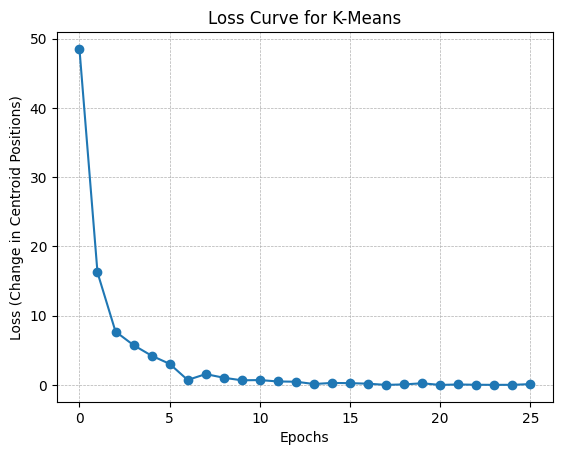

In [22]:
# Plot the loss curve after running k-means
lossPlot(loss)

## Question 04

Please use the ***first 4000 samples*** as the **training set** and ***remaining 2000 samples*** as the **validation set**, and design a way to choose the **best k** in k-means algorithm.

In [23]:
# Training set
X_train = X.values[:4000]
y_train = y.values[:4000]

# Testing set
X_test = X.values[4000:]
y_test = y.values[4000:]

# Range of k values to test
k_values = range(1,11)
loss_values = []

In [24]:
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (4000, 784)
Testing set shape: (2000, 784)


In [25]:
for k in k_values:
    loss = []
    clusters, cluster_center, loss = k_means(X_train, k)
    loss_values.append(np.sum(loss))

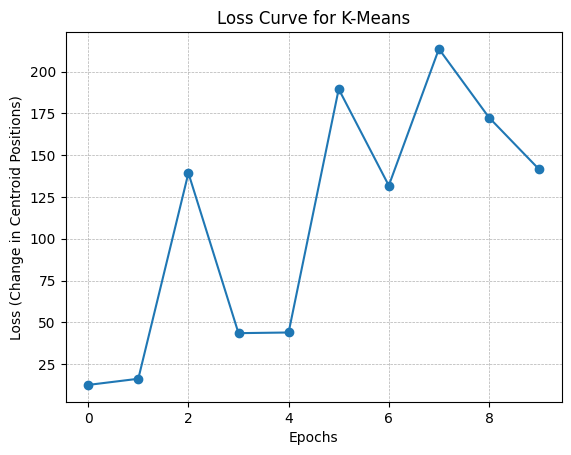

In [26]:
lossPlot(loss_values)

In [27]:
best_k = k_values[np.argmin(loss_values)]
print(f"Best k based on minimum loss:\t{best_k}")

Best k based on minimum loss:	1


## Question 05

Please implement kernel k-means algorithm with RBF-kernel, that is, 

$$k(\mathbf{x}_i,\mathbf{x}_j) = \exp(\frac{-\|\mathbf{x}_i - \mathbf{x}_j\|_2^2}{2\sigma^2})$$

where the hyper-parameter can be empirically set to,

$$2\sigma^2 = \frac{1}{N^2} \sum_{i=1}^{N}\sum_{j=1}^{N} \| \mathbf{x}_i -\mathbf{x}_j\|_2^2$$

Please only use the first 500 samples and cluster the them into 5 groups. This is for reducing the running time of your code.

**Tips**: If you can use matrix operations to replace summations, your code will be more efficient. However, this is just optional.

In [13]:
def cal_RBF(x):
    ## implement RBF method
    n = x.shape[0]
    # ==============================================================
    # "You need to initialize k"
    kernel_x = np.zeros((n, n))

    # ==============================================================
    sigma = 0

    for i in range(n):
        for j in range(n):
            # ==============================================================
            # "You need to implement sigma here"
            distance_squared = np.linalg.norm(x[i] - x[j]) ** 2
            sigma += distance_squared

            # ==============================================================
    sigma = sigma/(n**2)

    for i in range(n):
        for j in range(n):
            # ==============================================================
            # "You need to implement kernel x here"
            kernel_x[i, j] = np.exp(-np.linalg.norm(x[i] - x[j])**2)/(2 * sigma)

            # ==============================================================
    return kernel_x

In [14]:
kernel_x = cal_RBF(X_train)

In [15]:
clusters, cluster_center = k_means(kernel_x, k)